# BDT-similar

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import uproot
import awkward as ak

import mplhep
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import auc, roc_curve
from sklearn.model_selection import KFold
from xgboost import XGBClassifier


In [2]:
###this is for creating a CMS-like plot
def create_figure( x_axis
                 , y_axis
                 , top_label = f'2.3 $\mathrm{{fb^{{-1}}}}$, 2015 (13 TeV)'
                 , plot_type = 'Open  Data' ):

    fig = plt.figure()
    plt.xlabel(x_axis, fontsize=21, fontname='Helvetica')
    plt.ylabel(y_axis, fontsize=21, fontname='Helvetica')
    plt.rcParams["figure.figsize"] = (9,9)
    plt.tick_params(axis='both', labelsize=15)
    
    ax = fig.gca()
    ax.minorticks_on()
    ax.tick_params(bottom=True, top=True, left=True, right=True, direction='in', which='both')
    ax.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False, direction='in', which='both')
    plt.rcParams['font.family'] = 'Helvetica'
    ax.text(0.01, 1.05, '$\\bf{CMS}$', transform=ax.transAxes, ha='left', va='top', fontsize= 22)
    ax.text(0.13, 1.053, '$\\it{}$'.format(plot_type), transform=ax.transAxes, ha='left', va='top', fontsize= 22)
    #ax.text(0.05, 0.90, "$\\it{plot_type}$", transform=ax.transAxes, ha='left', va='top')
    
    ax.text(1, 1.055, top_label, transform=ax.transAxes, ha='right', va='top', fontsize= 22)


In [25]:
# Load the .npy files
#signal tttt
n_jets_sig = np.load('n_jets_sig.npy')
n_bjets_sig = np.load('n_bjets_sig.npy')
ht_sig = np.load('ht_sig.npy')
htb_sig = np.load('htb_sig.npy')
htratio_sig = np.load('htratio_sig.npy')

#data
n_jets_data = np.load('n_jets_data.npy')
n_bjets_data = np.load('n_bjets_data.npy')
ht_data = np.load('ht_data.npy')
htb_data = np.load('htb_data.npy')
htratio_data = np.load('htratio_data.npy')

#background (including tt)
n_jets_bkg = np.load('n_jets_bkg.npy')
n_bjets_bkg = np.load('n_bjets_bkg.npy')
ht_bkg = np.load('ht_bkg.npy')
htb_bkg = np.load('htb_bkg.npy')
htratio_bkg = np.load('htratio_bkg.npy')

#tt
n_jets_tt = np.load('n_jets_tt.npy')
n_bjets_tt = np.load('n_bjets_tt.npy')
ht_tt = np.load('ht_tt.npy')
htb_tt = np.load('htb_tt.npy')
htratio_tt = np.load('htratio_tt.npy')


print(len(n_jets_bkg))
print(len(n_bjets_data))

72848
487


974


findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


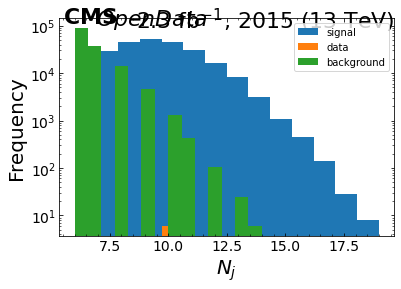

In [4]:
fig = create_figure( f'$N_{{j}}$'
                   , 'Frequency'
                    )
print(len(n_jets_data))
plt.hist(n_jets_sig, bins=14, label = 'signal')
plt.hist(n_jets_data, bins=14, label = 'data')
plt.hist(n_jets_bkg, bins=14, label = 'background')
#plt.hist2d(n_jets_data, n_bjets_data/n_jets_data, bins=(30, 30), cmap= plt.cm.Reds)
#plt.hexbin(all_histograms["n_jets_data"], all_histograms["n_bjets_data"], gridsize=(50,50))
#plt.colorbar()
plt.yscale('log') 
plt.legend()
plt.show()

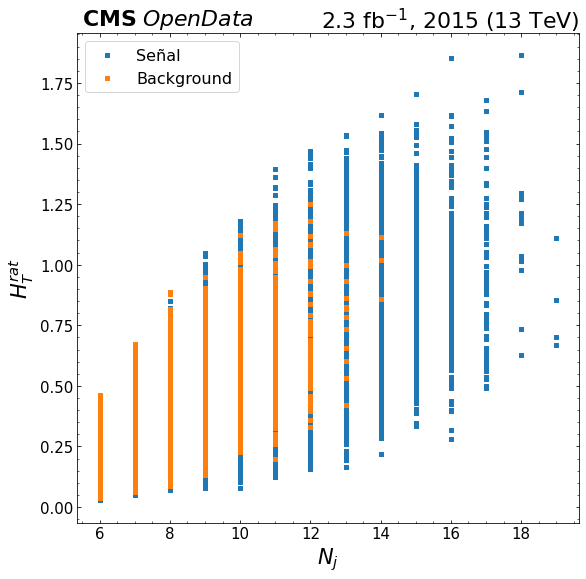

In [44]:
fig = create_figure( "$N_{{j}}$"
                   , "$H_T^{{rat}}$"
                    )
    
plt.scatter(n_jets_sig, htratio_sig, s=10, marker=',', label='Señal')
plt.scatter(n_jets_bkg, htratio_bkg, s=10, marker=',', label='Background')
plt.legend(fontsize='large')
plt.legend(fontsize=16)

#plt.savefig('hratVsnjets.png')
plt.show()

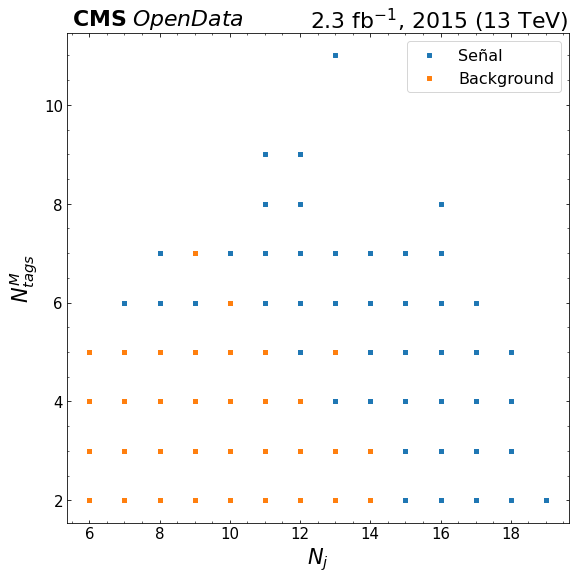

In [45]:
fig = create_figure( f'$N_{{j}}$'
                   , f'$N_{{tags}}^{{M}}$'
                    )
    
plt.scatter(n_jets_sig, n_bjets_sig, s=10, marker=',', label='Señal')
plt.scatter(n_jets_bkg, n_bjets_bkg, s=10, marker=',', label='Background')
plt.legend(fontsize=16)

plt.savefig('nbjetsVsnjets.png')
plt.show()

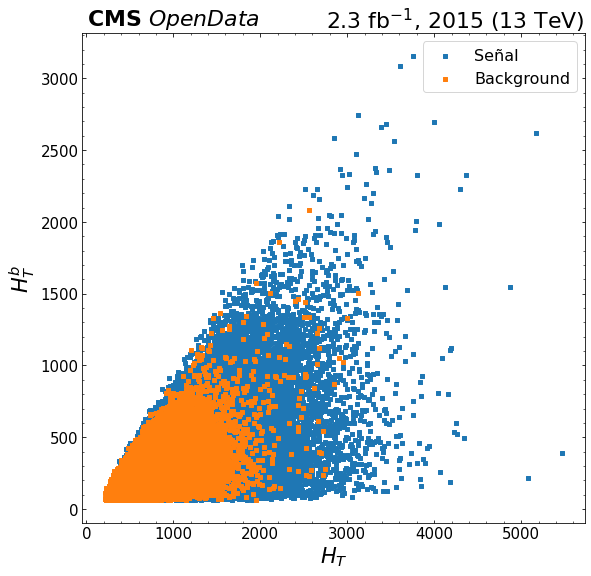

In [46]:
fig = create_figure( f'$H_T$'
                   , f'$H_T^{{b}}$'
                    )
    
plt.scatter(ht_sig, htb_sig, s=10, marker=',', label='Señal')
plt.scatter(ht_bkg, htb_bkg, s=10, marker=',', label='Background')
plt.legend(fontsize=16)

plt.savefig('htbVsHT.png')
plt.show()

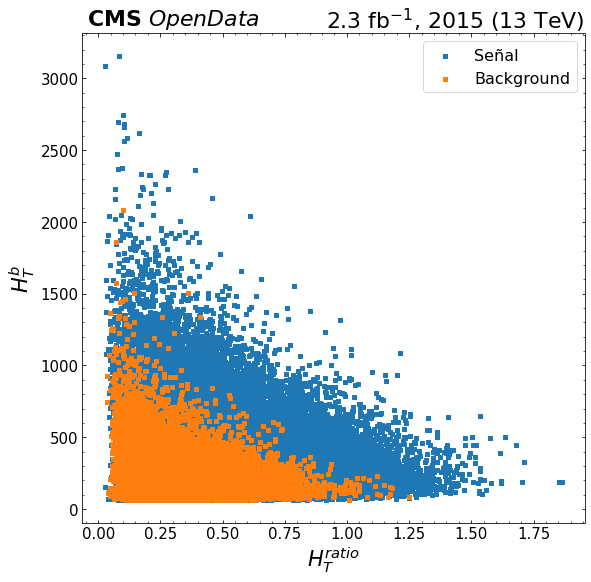

In [47]:
fig = create_figure( f'$H_T^{{ratio}}$'
                   , f'$H_T^{{b}}$'
                    )
    
plt.scatter(htratio_sig, htb_sig, s=10, marker=',', label='Señal')
plt.scatter(htratio_bkg, htb_bkg, s=10, marker=',', label='Background')
plt.legend(fontsize=16)

plt.savefig('htbVsHTratio.png')
plt.show()

# BDT-like Analysis

 First choose some variables which have good discriminating power for the classifier to use

In [35]:
training_columns = [
    'n_jets',
    'htratio',
    'htb',
    'htotal',
]
# Store training_columns
%store training_columns

Stored 'training_columns' (list)


In [36]:
## Creating data frames
#data
data = {
    'n_jets': n_jets_data,
    'htratio': htratio_data,
    'htb': htb_data,
    'htotal': ht_data,
}
data_df = pd.DataFrame(data)

#signal
sig = {
    'n_jets': n_jets_sig,
    'htratio': htratio_sig,
    'htb': htb_sig,
    'htotal': ht_sig,
}
sig_df = pd.DataFrame(sig)

#background
bkg = {
    'n_jets': n_jets_bkg,
    'htratio': htratio_bkg,
    'htb': htb_bkg,
    'htotal': ht_bkg,
}
background = pd.DataFrame(bkg)



# We need to set the background and signal categories for our dataframes:

bkg_df = background.copy()
bkg_df['category'] = 0  # Use 0 for background
sig_df['category'] = 1  # Use 1 for signal


In [37]:
# Now merge the data together
training_data = pd.concat([bkg_df, sig_df], copy=True, ignore_index=True)
# Store training_data for later
%store training_data

#print(training_data)

Stored 'training_data' (DataFrame)


### We then define different classifiers we want to use

In [38]:
# Train the Gradient Booster
bdt_1 = GradientBoostingClassifier()
bdt_1.fit(training_data[training_columns], training_data['category'])
for df in [sig_df, bkg_df, data_df, training_data]:
    df['BDT_G'] = bdt_1.predict_proba(df[training_columns])[:,1]

In [39]:
# Train the Adaptive Booster
bdt_2 = AdaBoostClassifier()
bdt_2.fit(training_data[training_columns], training_data['category'])
for df in [sig_df, bkg_df, data_df, training_data]:
    df['BDT'] = bdt_2.predict_proba(df[training_columns])[:,1]

In [40]:
# Train XGBoost Classifier
xgboost_bdt = XGBClassifier()
xgboost_bdt.fit(training_data[training_columns], training_data['category'])
for df in [sig_df, bkg_df, data_df, training_data]:
    df['XGBoost_BDT'] = xgboost_bdt.predict_proba(df[training_columns])[:,1]

In [16]:
bdt_1.predict_proba(data_df[training_columns].head())

array([[0.90562201, 0.09437799],
       [0.8683182 , 0.1316818 ],
       [0.43920245, 0.56079755],
       [0.92587148, 0.07412852],
       [0.54851065, 0.45148935]])

In [41]:
y_score = bdt_1.predict_proba(training_data[training_columns])[:,1]
fpr, tpr, thresholds = roc_curve(training_data['category'], y_score)

true_rates = tpr[tpr >0.85]

perfomance = ak.count(true_rates)/ak.count(tpr)

print(perfomance)



0.3960199685427067


In [48]:
def plot_comparision(var, sig_df, bkg_df, data_df):
    
    fig = create_figure( 'BDT'
                   , 'Events'
                    )
    
    # create histograms
    hsig, bins = np.histogram(sig_df[var], bins=30, density=0)
    hbkg, bins = np.histogram(bkg_df[var], bins=bins, density=0)
    hdata, bins = np.histogram(data_df[var], bins=bins, density=0)
    
    # Compute the bin widths
    bin_widths = np.diff(bins)

    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    
    # Threshold for signal and background classification
    threshold = 0.6
    
    # Apply threshold selection to data
    data_above_threshold = data_df[data_df[var] > threshold]
    data_below_threshold = data_df[data_df[var] <= threshold]
    
    # Count the number of observed and background events
    N_observed = len(data_df)
    
    N_signal = len(sig_df)
    N_background = len(bkg_df)
    
    #scaling factor for plotting data using density =0
    scaling_factor = len(bkg_df)/len(data_df)
    
    # Calculate Poisson uncertainty for data histogram
    data_errors = np.sqrt(hdata)*scaling_factor
    sig_errors = np.sqrt(hsig)
    bkg_errors = np.sqrt(hbkg)
    
    # Plot histograms with error bars
    mplhep.histplot((hsig, bins), label='Señal', color='blue', fill=True, alpha=0.5)
    mplhep.histplot(hbkg, bins=bins, label='Background', color='red', hatch='/', alpha=1)
    #mplhep.histplot(hdata*scaling_factor, bins=bins, color='black')
    plt.errorbar(bin_centers, hdata*scaling_factor, yerr=data_errors, fmt='o', label='Data', color='black', capsize=5)
    #plt.bar(bin_centers, hsig, width=bin_widths, align='center', yerr=data_errors, capsize = 4,alpha=0.7)
    
    print(f"Number of Observed Events: {N_observed}")
    print(f"Number of Signal Events: {N_signal}")
    print(f"Number of Background Events: {N_background}")
    
    plt.xlabel(var)
    plt.xlim(bins[0], bins[-1])
    plt.yscale('log')
    plt.ylim(1,10e7)
    plt.legend(fontsize='large')
    plt.legend(fontsize=16)
    
    print("datos")
    print(hdata*scaling_factor)
    print("signal")
    print(hsig)
    print(sig_errors)
    print("bkg")
    print(hbkg)
    print(bkg_errors)


Number of Observed Events: 487
Number of Signal Events: 120845
Number of Background Events: 72848
datos
[18398.98151951  7030.50513347  7479.26078029  6731.33470226
  4188.38603696  2692.5338809   3290.87474333  1645.43737166
  2542.9486653   2094.19301848  1346.26694045  1346.26694045
   448.75564682  1795.02258727  1495.85215606   598.34086242
  1047.09650924   299.17043121   897.51129363   598.34086242
  1047.09650924   598.34086242   149.58521561   747.92607803
   897.51129363   448.75564682  1196.68172485   897.51129363
   448.75564682   448.75564682]
signal
[  385   523   751  1023   816   798   901   939   839   795   825   863
  1035  1099  1179  1083  1113  1369  1242  1504  1724  2138  2536  2817
  3216  3886  6117  9245 16068 54016]
[ 19.62141687  22.86919325  27.40437921  31.98437118  28.56571371
  28.24889378  30.01666204  30.64310689  28.96549672  28.19574436
  28.72281323  29.37686164  32.17141588  33.15116891  34.33656943
  32.90896534  33.36165464  37.          35.2420

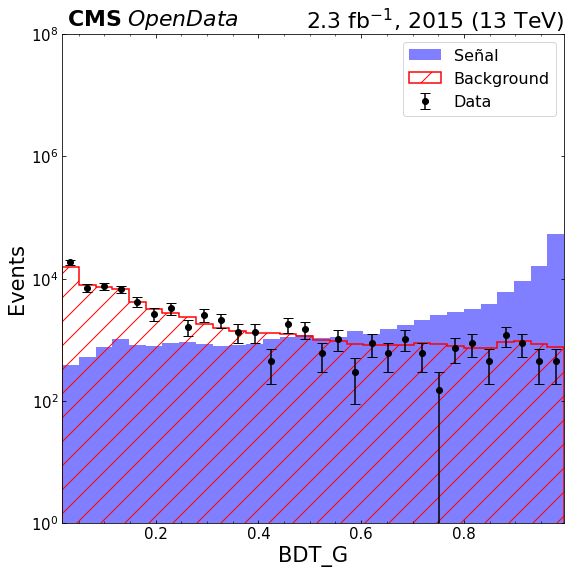

In [49]:
plot_comparision('BDT_G', sig_df, bkg_df, data_df)
plt.savefig('BDT_G.png')
plt.show()

Number of Observed Events: 487
Number of Signal Events: 120845
Number of Background Events: 72848
datos
[ 8227.18685832 27224.50924025 22437.78234086  9723.03901437
  3440.45995893   598.34086242     0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.        ]
signal
[  158  2111  7650 19497 32226 35193 18224  4753   162    21     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0   375   450    25]
[ 12.56980509  45.94562003  87.46427842 139.6316583  179.516016
 187.5979744  134.99629625  68.94200461  12.72792206   4.58257569
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.    

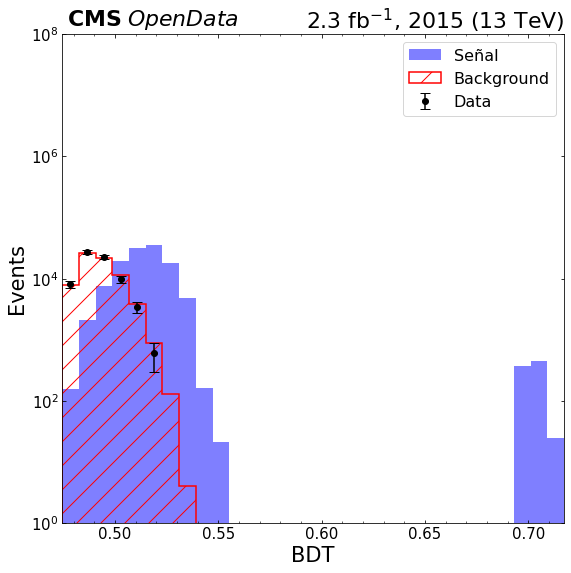

In [50]:
plot_comparision('BDT', sig_df, bkg_df, data_df)
plt.savefig('AdaBDT.png')
plt.show()

Number of Observed Events: 487
Number of Signal Events: 120845
Number of Background Events: 72848
datos
[12415.57289528  8825.52772074  7180.09034908  6880.91991786
  3290.87474333  2842.11909651  3590.04517454  2393.36344969
  1944.60780287  1346.26694045  1196.68172485  1196.68172485
  1495.85215606  1346.26694045  1495.85215606  1346.26694045
  1346.26694045   299.17043121  1346.26694045   448.75564682
   897.51129363   149.58521561   598.34086242   149.58521561
  1047.09650924   299.17043121  1196.68172485  1047.09650924
   747.92607803   299.17043121]
signal
[  211   480   710   832   704   739   844   860   816   876   732   888
   906  1165  1155  1240  1348  1417  1515  1441  2003  2219  2333  2998
  3888  4551  6558  9147 16161 52108]
[ 14.52583905  21.9089023   26.64582519  28.8444102   26.53299832
  27.18455444  29.05167809  29.3257566   28.56571371  29.59729717
  27.05549852  29.79932885  30.09983389  34.13209633  33.98529094
  35.21363372  36.7151195   37.64306045  38.9230

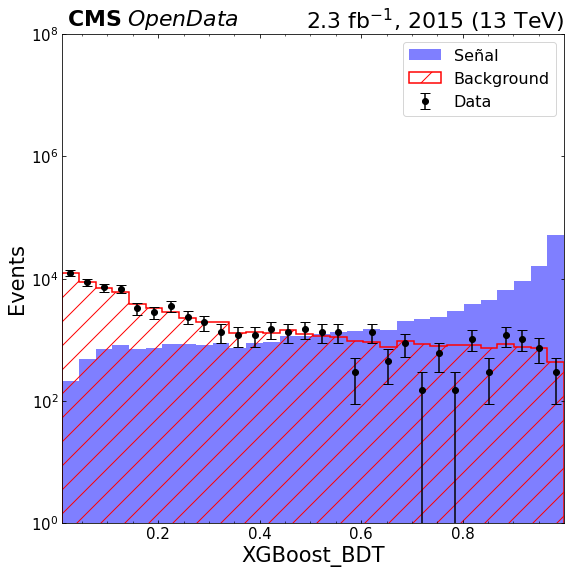

In [52]:
plot_comparision('XGBoost_BDT', sig_df, bkg_df, data_df)
plt.savefig('XGBoost_BDT.png')
plt.show()

In [53]:
def plot_roc(bdt, training_data, training_columns, label):

    y_score = bdt.predict_proba(training_data[training_columns])[:,1]
    fpr, tpr, thresholds = roc_curve(training_data['category'], y_score)
    area = auc(fpr, tpr)

    plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
    if label == 'AdaBoost':
        plt.plot(fpr, tpr, label=f'{label} (área = {area:.2f})')
    else:
        plt.plot(fpr, tpr, label=f'XGBoost (área = {area:.2f})')
    plt.xlim(0.0, 1.0)
    plt.ylim(0.0, 1.0)
    plt.legend(loc='lower right',fontsize=16)
    # We can make the plot look nicer by forcing the grid to be square
    plt.gca().set_aspect('equal', adjustable='box')
    
    true_rates = tpr[tpr > 0.92]

    perfomance = ak.count(true_rates)/ak.count(tpr)
    
    return float(perfomance)

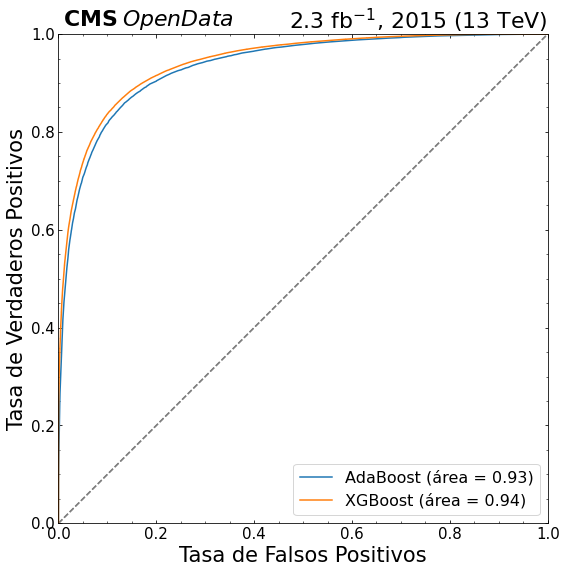

La seccion eficaz es $\sig$ = 242.919435866756


In [54]:

fig = create_figure( 'Tasa de Falsos Positivos'
                   , 'Tasa de Verdaderos Positivos'
                    )
    
efficiency = plot_roc(bdt_2, training_data, training_columns, 'AdaBoost')
efficiency2 = plot_roc(xgboost_bdt, training_data, training_columns, 'XGBoost')

plt.savefig('ROCCurves.png')
plt.show()

sigma = 102.0/(float(efficiency)*2.25638)

print(f'La seccion eficaz es $\\sig$ = {sigma}')